In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
from lib import trace_analysis
from lib import plots_analysis
from lib import trace_statistics
from lib import trace_classification
import csv
from lib.functions import *
import warnings 
warnings.filterwarnings('ignore')

/Users/lucamaiano/miniconda3/envs/elis/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0 or row[2].find('normal') >= 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)  

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7409:9:909:,grid_1bh-9_2019-02-20_00:30_,158,306.278481,25524.902846,159.765149,3,163.0,1038.0,0.21,9,BH
1,aaaa::212:740a:a:a0a:,grid_1bh-9_2019-02-20_00:30_,192,266.895833,6109.654014,78.164276,4,168.0,604.0,0.04,12,BH
2,aaaa::212:7402:2:202:,grid_1bh-9_2019-02-20_00:30_,186,145.939247,5965.375370,77.235843,2,73.4,622.0,0.07,7,BH
3,aaaa::212:7408:8:808:,grid_1bh-9_2019-02-20_00:30_,168,245.690476,24507.137154,156.547556,2,102.0,837.0,0.16,13,BH
4,aaaa::212:7403:3:303:,grid_1bh-9_2019-02-20_00:30_,198,103.561616,5068.714255,71.194903,1,40.0,418.0,0.01,11,BH


Stats for single network

In [3]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 16)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 16, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 16, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 16, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,grid_1bh-7_2019-02-19_22:13_,BH,0.275,0.220,0.200,0.240,0.170,0.100,0.190,0.215,0.240,0.230,0.305,0.170,0.080,0.255,9.223372e+18,9.223372e+18
1,grid_1bh-9_2019-02-20_00:30_,BH,0.210,0.100,0.205,0.125,0.250,0.130,0.015,0.075,0.025,0.010,0.160,0.070,0.040,0.045,9.223372e+18,9.223372e+18
2,grid_1gh30-7_2019-02-19_22:35_,GH,0.335,0.825,0.475,0.235,0.705,0.480,0.890,0.550,0.380,0.885,0.455,0.695,0.705,0.350,4.250000e-01,6.350000e-01
3,grid_1gh30-9_2019-02-20_00:12_,GH,0.155,0.220,0.790,0.120,0.060,0.220,0.180,0.115,0.760,0.125,0.180,0.070,0.105,0.320,1.550000e-01,6.500000e-02
4,grid_1gh50-7_2019-02-19_22:53_,GH,0.270,0.650,0.300,0.345,0.170,0.205,0.350,0.360,0.165,0.315,0.160,0.300,0.145,0.580,6.250000e-01,1.700000e-01


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

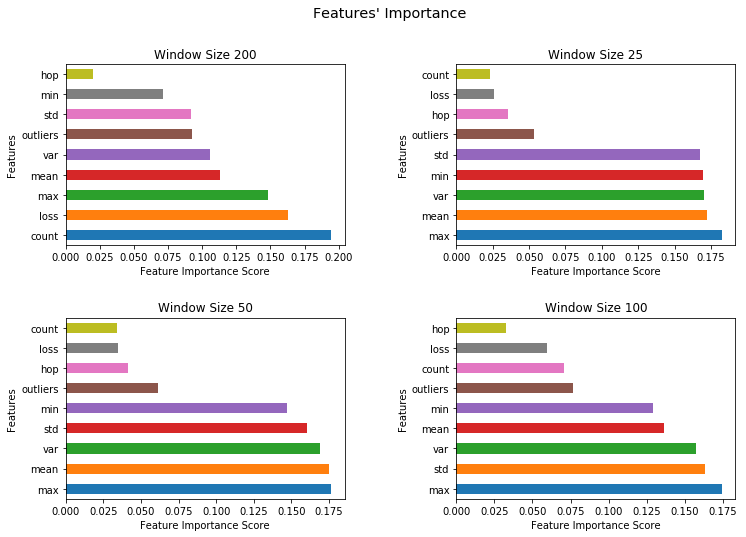

In [4]:
plots_analysis.random_forests_features_selection(trace_stats)

In [5]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [6]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [7]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [8]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [9]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

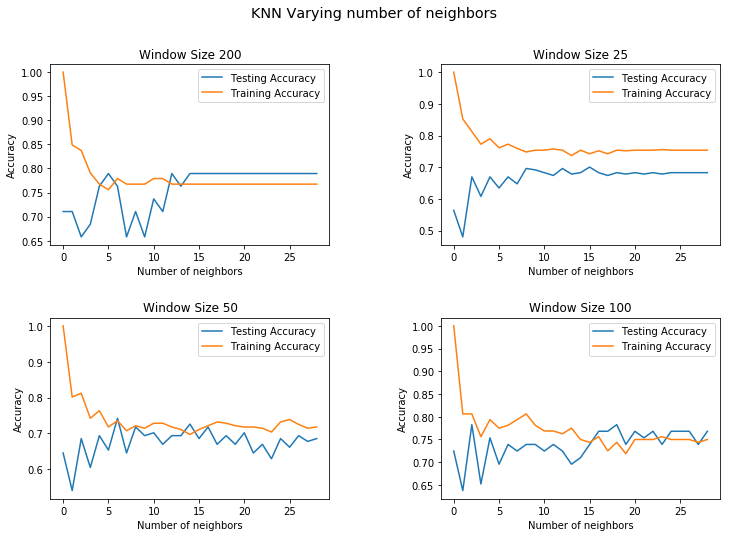

In [10]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [11]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [12]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [13]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [14]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [15]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [16]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [17]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [18]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [19]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=10)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [20]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])
                    

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [21]:
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [22]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])


Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Per Node Results
Results from each model

In [23]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.631579,0.445833,0.445833,0.445833,0.104455,0.004858
1,Random Forest,25,0.638767,0.485735,0.493772,0.458392,0.128367,0.007430
2,Random Forest,50,0.709677,0.538324,0.533752,0.535000,0.106334,0.006602
3,Random Forest,100,0.681159,0.439549,0.465212,0.445175,0.092678,0.005494
4,KNN,200,0.789474,0.394737,0.500000,0.441176,0.000553,0.000810
5,KNN,25,0.682819,0.341410,0.500000,0.405759,0.000965,0.001084
6,KNN,50,0.717742,0.468815,0.482339,0.467550,0.000827,0.001169
7,KNN,100,0.768116,0.642308,0.543632,0.532203,0.000697,0.001546
8,SVM,200,0.789474,0.394737,0.500000,0.441176,0.001160,0.000909
9,SVM,25,0.682819,0.341410,0.500000,0.405759,0.007849,0.001338


Here we plot the average results for each model computed with cross validation

In [24]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.695744
1,Random Forest,25,0.647898
2,Random Forest,50,0.662264
3,Random Forest,100,0.708626
4,KNN,200,0.696051
5,KNN,25,0.711380
6,KNN,50,0.710754
7,KNN,100,0.704072
8,SVM,200,0.774513
9,SVM,25,0.732458


# Network Results
Here we print the results from each model on the whole network

In [25]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,1.000000,1.000000,1.000000,1.000000,0.089433,0.004255
1,Random Forest,25,0.850000,0.425000,0.500000,0.459459,0.080387,0.004286
2,Random Forest,50,0.700000,0.437500,0.388889,0.411765,0.089319,0.004766
3,Random Forest,100,0.400000,0.250000,0.333333,0.285714,0.082623,0.004830
4,KNN,200,0.666667,0.333333,0.500000,0.400000,0.000210,0.000526
5,KNN,25,0.850000,0.425000,0.500000,0.459459,0.000349,0.000495
6,KNN,50,0.900000,0.450000,0.500000,0.473684,0.000303,0.000596
7,KNN,100,0.600000,0.300000,0.500000,0.375000,0.000302,0.000366
8,SVM,200,1.000000,1.000000,1.000000,1.000000,0.000460,0.000256
9,SVM,25,0.850000,0.425000,0.500000,0.459459,0.000464,0.000216


Here we plot the average results for each model computed with cross validation

In [26]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.777778
1,Random Forest,25,0.734488
2,Random Forest,50,0.751515
3,Random Forest,100,0.500000
4,KNN,200,0.777778
5,KNN,25,0.297258
6,KNN,50,0.436364
7,KNN,100,0.555556
8,SVM,200,1.000000
9,SVM,25,0.750361
